In [223]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [224]:
con = sqlite3.connect("../db.sqlite3")
df = pd.read_sql_query(
    "SELECT restaurant_orderitem.order_id, restaurant_order.datetime, restaurant_product.name, restaurant_product.price, restaurant_orderitem.quantity "
    "FROM restaurant_order "
    "INNER JOIN restaurant_orderitem "
    "ON restaurant_orderitem.order_id = restaurant_order.id "
    "INNER JOIN restaurant_product "
    "ON restaurant_orderitem.product_id = restaurant_product.id;", con)

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

(-1.0999999979914505,
 1.0999999999043548,
 -1.0999999814299763,
 1.099999979291738)

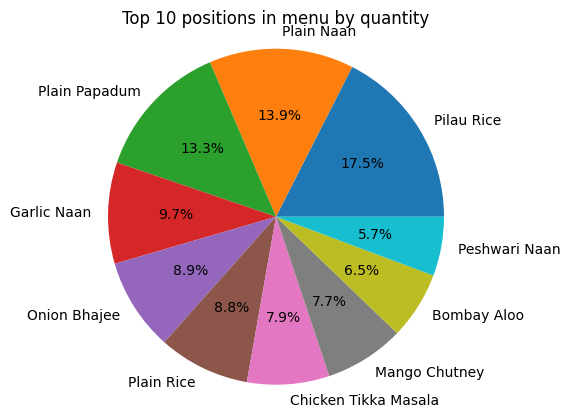

In [225]:
df_top_name = df.groupby(['name'])['name'].count().nlargest(10, keep="first").rename("count")
vals = df_top_name.to_list()
labels = df_top_name.index.to_list()

fig, ax = plt.subplots()
ax.set_title('Top 10 positions in menu by quantity')
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

(-1.0999999026228804,
 1.0999999953629942,
 -1.0999999666365397,
 1.0999999978833435)

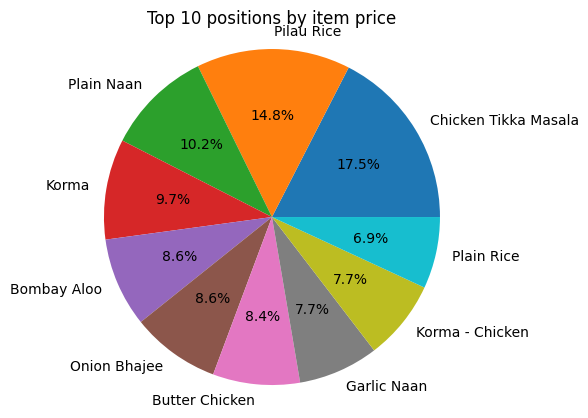

In [226]:
df["item_price"] = df["price"] * df["quantity"]
df_top_price = df.groupby(['name'])['item_price'].sum().nlargest(10, keep="first")
vals = df_top_price.to_list()
labels = df_top_price.index.to_list()
fig, ax = plt.subplots()
ax.set_title('Top 10 positions by item price')
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

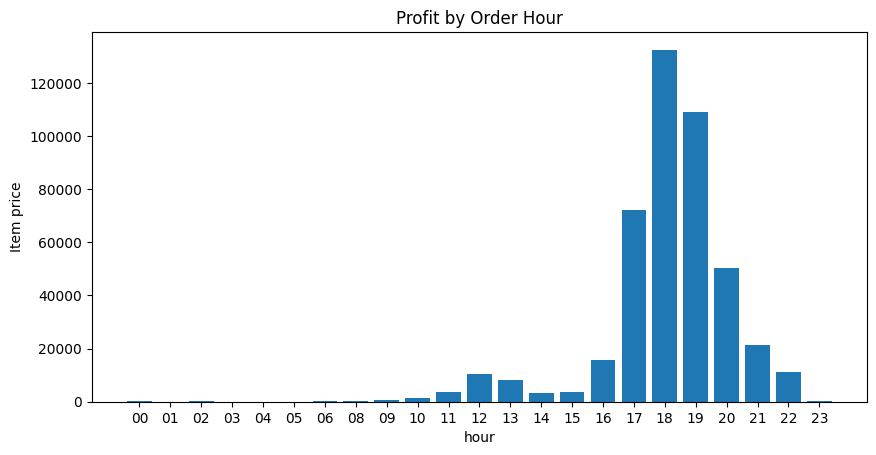

In [227]:
df["datetime"] = pd.to_datetime(df["datetime"])
df['hour'] = df['datetime'].dt.strftime("%H")
df_order_hour_price = df.groupby(['hour'])['item_price'].sum()
item_price = df_order_hour_price.to_list()
hour = df_order_hour_price.index.to_list()
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.set_title('Profit by Order Hour')
ax.set_xlabel('hour')
ax.set_ylabel('Item price')
ax.bar(hour, item_price)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

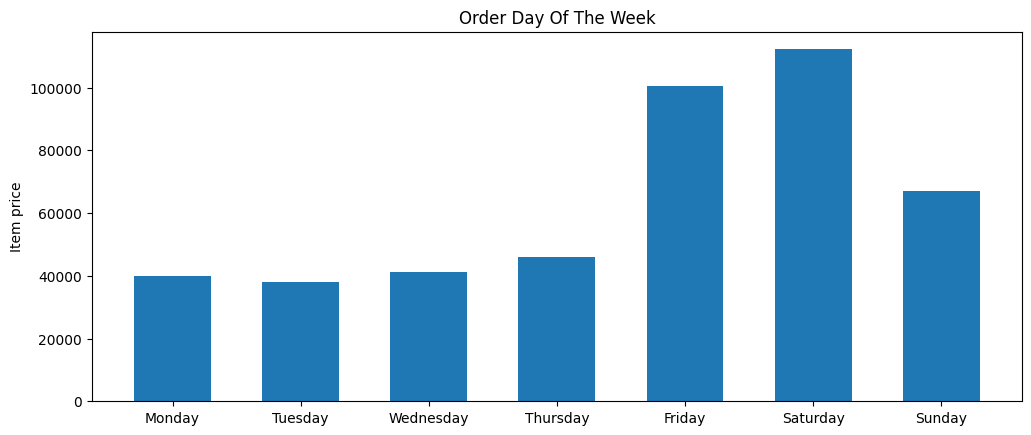

In [229]:
df["day_name"] = df["datetime"].dt.day_name()
df["day_num"] = df["datetime"].dt.weekday
df_order_weekday_price = df.groupby(['day_num', 'day_name'])['item_price'].sum()
item_price = df_order_weekday_price.to_list()
day_name = df_order_weekday_price.index.to_list()
day = [day for num, day in day_name]
fig, ax = plt.subplots()
fig.set_figwidth(12)
ax.set_title('Order Day Of The Week')
ax.set_ylabel('Item price')
ax.bar(day, item_price, width=0.6)
plt.show()